### IMDB Reviews

In [ ]:
import tensorflow
print(tensorflow.__version__)

2.5.0


In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import csv
import json

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
import tensorflow_datasets as tfds      # prebuilt datasets

imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)          # return data and metadata

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2A1C8Y/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2A1C8Y/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2A1C8Y/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [15]:
train_data, test_data = imdb['train'], imdb['test']         # data split into 25k train, 25k test

In [16]:
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s,l in train_data:            # s & l are tensors
    training_sentences.append(s.numpy().decode('utf8'))     # tensor -> numpy -> extracting sentences 
    training_labels.append(l.numpy())                       # tensor -> numpy -> extracting labels 
  
for s,l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())

In [ ]:
training_sentences[:2]

["This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
 'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development wa

In [ ]:
training_labels[:2]

[0, 0]

In [ ]:
type(training_labels)

list

In [17]:
# when training, labels should be numpy arrays

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [18]:
vocab_size = 10000            # number of unique words in the corpus
embedding_dim = 16            # number of dimensions we wish to embed each word into
max_length = 120              # maximum length of document/sentence
trunc_type='post'
oov_tok = "<OOV>"             # out of vocab words in test set will be marked OOV

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),          # can use GlobalAveragePooling1D also
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 11526     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [20]:
num_epochs = 10
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 5s 6ms/step - loss: 0.4818 - accuracy: 0.7548 - val_loss: 0.3377 - val_accuracy: 0.8539
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 0.2408 - accuracy: 0.9067 - val_loss: 0.3736 - val_accuracy: 0.8365
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 0.1029 - accuracy: 0.9710 - val_loss: 0.4476 - val_accuracy: 0.8272
Epoch 4/10
782/782 [==============================] - 4s 6ms/step - loss: 0.0269 - accuracy: 0.9960 - val_loss: 0.5254 - val_accuracy: 0.8268
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0062 - accuracy: 0.9996 - val_loss: 0.5943 - val_accuracy: 0.8272
Epoch 6/10
782/782 [==============================] - 4s 6ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.6457 - val_accuracy: 0.8285
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 8.9063e-04 - accuracy: 1.0000 - val_loss: 0.6903 - val_accuracy: 0.8289
Ep

In [21]:
# getting results of embedding layer

e = model.layers[0]             
weights = e.get_weights()[0]          # getting weights of that layer
print(weights.shape) # shape: (vocab_size (10k words in corpus), embedding_dim (16 dimensions))

(10000, 16)


In [22]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])      # just reversing {Hello : 1} to {1 : Hello}

In [25]:
# just checking out how it does decoding

print(training_sentences[0])          # sample original sentence

def decode_review(text):              # decoding the review
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[0]))       # sample decoded sentence

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
? ? ? this was an absolutely terrible movie don't be <OOV> in by christopher walken or michael <OOV> both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie's ridiculous storyline this movie is an early nineties us propa

In [26]:
# code for getting vectors and metadata for tensorflow projector

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")                                      # actual word associated with dimensions
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")   # write value of 16 dimensions per word
out_v.close()
out_m.close()

In [27]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Sarcasm Dataset

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /content/sarcasm.json

--2021-08-06 03:29:37--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 2607:f8b0:4023:c0d::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/content/sarcasm.json’

/content/sarcasm.js 100%[===================>]   5.38M  --.-KB/s    in 0.02s   

2021-08-06 03:29:37 (254 MB/s) - ‘/content/sarcasm.json’ saved [5643545/5643545]



In [5]:
with open("/content/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:                          # separating labels and sentences
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [ ]:
sentences[:3]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild"]

In [ ]:
labels[:3]

[0, 0, 1]

In [6]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000         # 20000 for train, 7000 for test

In [7]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [8]:
# tokenize, sequencing, padding

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [11]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [12]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 6s - loss: 0.6767 - accuracy: 0.5677 - val_loss: 0.6316 - val_accuracy: 0.6317
Epoch 2/30
625/625 - 2s - loss: 0.4705 - accuracy: 0.8150 - val_loss: 0.3930 - val_accuracy: 0.8351
Epoch 3/30
625/625 - 2s - loss: 0.3210 - accuracy: 0.8704 - val_loss: 0.3580 - val_accuracy: 0.8462
Epoch 4/30
625/625 - 2s - loss: 0.2693 - accuracy: 0.8944 - val_loss: 0.3428 - val_accuracy: 0.8524
Epoch 5/30
625/625 - 2s - loss: 0.2330 - accuracy: 0.9086 - val_loss: 0.3397 - val_accuracy: 0.8542
Epoch 6/30
625/625 - 2s - loss: 0.2052 - accuracy: 0.9204 - val_loss: 0.3432 - val_accuracy: 0.8571
Epoch 7/30
625/625 - 2s - loss: 0.1830 - accuracy: 0.9317 - val_loss: 0.3556 - val_accuracy: 0.8524
Epoch 8/30
625/625 - 2s - loss: 0.1645 - accuracy: 0.9381 - val_loss: 0.3748 - val_accuracy: 0.8474
Epoch 9/30
625/625 - 2s - loss: 0.1490 - accuracy: 0.9458 - val_loss: 0.3820 - val_accuracy: 0.8508
Epoch 10/30
625/625 - 2s - loss: 0.1355 - accuracy: 0.9512 - val_loss: 0.4006 - val_accuracy: 0.8505

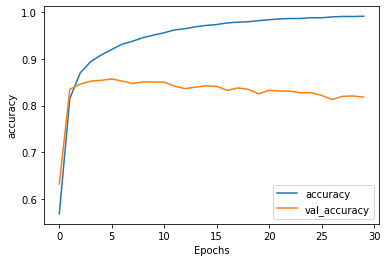

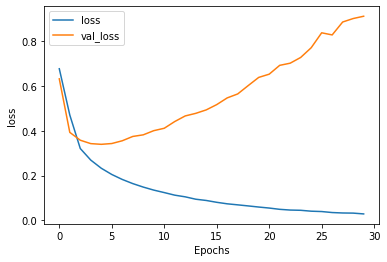

In [13]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[9.3595600e-01]
 [2.2793395e-06]]


## Training on IMDB subwords

In [29]:
# here the tokenization is done on sub words instead of words
# and this may give accuracy issues

import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteKN2CXS/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteKN2CXS/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteKN2CXS/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [30]:
train_data, test_data = imdb['train'], imdb['test']

In [31]:
tokenizer = info.features['text'].encoder

In [32]:
print(tokenizer.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

In [33]:
sample_string = 'TensorFlow, from basics to mastery'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))


Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


In [34]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


In [35]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_data.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

In [36]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


In [37]:
num_epochs = 5

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/5
391/391 [==============================] - 12s 28ms/step - loss: 0.6610 - accuracy: 0.6386 - val_loss: 0.5914 - val_accuracy: 0.7793
Epoch 2/5
391/391 [==============================] - 11s 27ms/step - loss: 0.4795 - accuracy: 0.8274 - val_loss: 0.4145 - val_accuracy: 0.8527
Epoch 3/5
391/391 [==============================] - 11s 27ms/step - loss: 0.3402 - accuracy: 0.8816 - val_loss: 0.3568 - val_accuracy: 0.8540
Epoch 4/5
391/391 [==============================] - 11s 27ms/step - loss: 0.2791 - accuracy: 0.8994 - val_loss: 0.3238 - val_accuracy: 0.8708
Epoch 5/5
391/391 [==============================] - 12s 29ms/step - loss: 0.2449 - accuracy: 0.9128 - val_loss: 0.3099 - val_accuracy: 0.8790


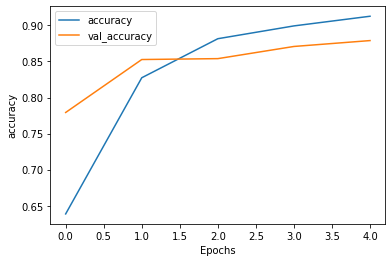

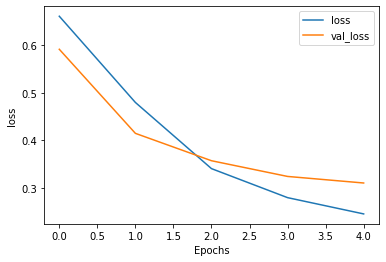

In [38]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Exercise 10

Running on BBC data.

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /content/bbc-text.csv

--2021-08-06 04:21:27--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 2607:f8b0:4023:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/csv]
Saving to: ‘/content/bbc-text.csv’

/content/bbc-text.c 100%[===================>]   4.82M  --.-KB/s    in 0.02s   

2021-08-06 04:21:27 (218 MB/s) - ‘/content/bbc-text.csv’ saved [5057493/5057493]



In [15]:
df = pd.read_csv('bbc-text.csv')
df.shape

(2225, 2)

In [18]:
df.head(10)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


In [19]:
df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [4]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [5]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))

153


In [6]:
with open("/content/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        sentence = row[1]
        for word in stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
        sentences.append(sentence)

print(len(labels))
print(len(sentences))
print(sentences[0])

2225
2225
tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us s tivo uk s sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take off europe lack high-definition programming. not can people forward wind adverts  can also forget abiding network channel schedules  putting together a-la-carte entertai

In [7]:
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

1780
1780
1780
445
445


In [8]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

449
120
200
120
192
120


In [9]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 120)


In [10]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 150       
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [13]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/30
56/56 - 1s - loss: 1.7655 - accuracy: 0.2140 - val_loss: 1.7310 - val_accuracy: 0.3416
Epoch 2/30
56/56 - 0s - loss: 1.6876 - accuracy: 0.3624 - val_loss: 1.6377 - val_accuracy: 0.4180
Epoch 3/30
56/56 - 0s - loss: 1.5743 - accuracy: 0.5028 - val_loss: 1.5150 - val_accuracy: 0.5079
Epoch 4/30
56/56 - 0s - loss: 1.4274 - accuracy: 0.5798 - val_loss: 1.3578 - val_accuracy: 0.5730
Epoch 5/30
56/56 - 0s - loss: 1.2570 - accuracy: 0.6096 - val_loss: 1.2057 - val_accuracy: 0.6517
Epoch 6/30
56/56 - 0s - loss: 1.1054 - accuracy: 0.6854 - val_loss: 1.0816 - val_accuracy: 0.6629
Epoch 7/30
56/56 - 0s - loss: 0.9814 - accuracy: 0.7483 - val_loss: 0.9805 - val_accuracy: 0.7483
Epoch 8/30
56/56 - 0s - loss: 0.8739 - accuracy: 0.8309 - val_loss: 0.8831 - val_accuracy: 0.8472
Epoch 9/30
56/56 - 0s - loss: 0.7695 - accuracy: 0.8927 - val_loss: 0.7860 - val_accuracy: 0.8427
Epoch 10/30
56/56 - 0s - loss: 0.6603 - accuracy: 0.9062 - val_loss: 0.6795 - val_accuracy: 0.8831
Epoch 11/30
56/56 -

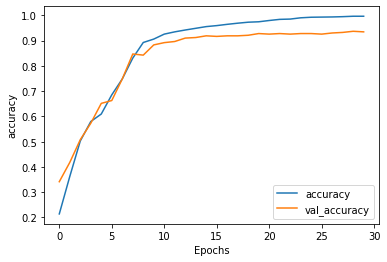

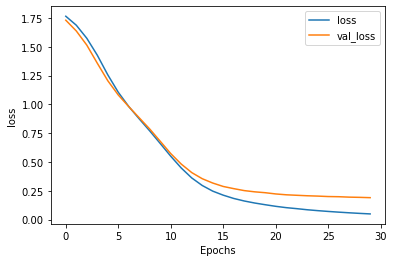

In [14]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")